**Run all the cells below to make sure everything is working and ready to go. All cells should run without error.**

### Test Matplotlib and Plotting

In [60]:
#Finding Lanes test for Robert Dyke

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

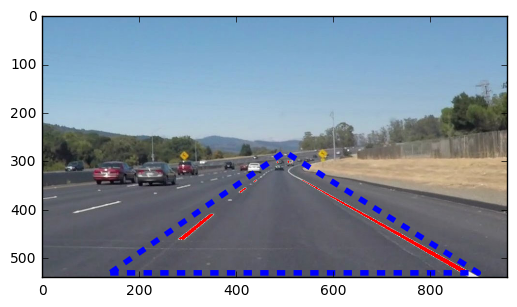

In [61]:
#img = mpimg.imread('test.jpg')

img = mpimg.imread('solidWhiteCurve.jpg')
#img = mpimg.imread('solidWhiteRight.jpg')
#img = mpimg.imread('solidYellowCurve.jpg')
#img = mpimg.imread('solidYellowCurve2.jpg')
#img = mpimg.imread('solidYellowLeft.jpg')
#img = mpimg.imread('whiteCarLaneSwitch.jpg')



plt.imshow(img)

ysize = img.shape[0]
xsize = img.shape[1]
color_select = np.copy(img)
line_image = np.copy(img)

# Define color selection criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]


# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
left_bottom = [140,530]
right_bottom = [900, 530]
apex = [500,280]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
color_thresholds = (img[:,:,0] < rgb_threshold[0]) \
            | (img[:,:,1] < rgb_threshold[1]) \
            | (img[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

        # Mask color selection
color_select[color_thresholds] = [0,0,0]

# Color pixels red which are inside the region of interest
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
plt.imshow(img)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]


plt.plot(x, y, 'b--', lw=4)
#plt.imshow(color_select)
plt.imshow(line_image)

### Test OpenCV

In [62]:
import cv2

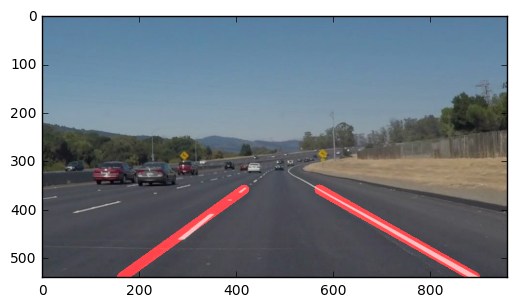

In [63]:
# convert the image to grayscale

#gray = cv2.cvtColor(line_image, cv2.COLOR_RGB2GRAY)
def get_slope(x1, y1, x2,y2):
    return ((y2 - y1)/(x2 - x1))

def draw_lines(img, lines, color=[255,0,0], thickness=20):
    #Parts of this draw_lines object came from solutions posted on the forums
    #My original draw_lines had short comings that interfered with using process_image on movies
    #I substituted this draw_lines to verify that my original draw_lines was the source of the problems.
    #By the time I had figured the root of the problem out. I had more development invested in this draw_lines 
    #So I have incorporated it into my code.
    
    #top = 320 # field of vision of camara
    #bottom = 540 # height of image
    
    #top = 400 # field of vision of camara
    #bottom = 800 # height of image
    
    imshape = img.shape
    ysize = imshape[0]
    xsize = imshape[1]
    top = int(ysize * .666)
    
    bottom = ysize
    #below are arrays to hold lines that pass the slope test
    x1_left = []
    y1_left = []
    x2_left = []
    y2_left = []
    x1_right = []
    y1_right = []
    x2_right = []
    y2_right = []
    
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            # Draw line segments in blue for error checking during development and testing.
            #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1, y1, x2, y2)
            #splitting the lines into less than and greater than zero slopes should divide lines into left and right lane lines
            #
            if slope < 0:
                # eliminate lines that can not be the lane lines
                #if slope > -.5 or slope < -.8: tried -.55 and -.7 made it worse, as did -.6 and -.7
                if slope > -.5 or slope < -.8:
                    continue        
                x1_left.append(x1)
                y1_left.append(y1)
                x2_left.append(x2)
                y2_left.append(y2)
            else:
                # eliminate lines that can not be the lane lines
                #if slope < .5 or slope > .8:
                if slope < .5 or slope > .8:
                    continue        
                x1_right.append(x1)
                y1_right.append(y1)
                x2_right.append(x2)
                y2_right.append(y2)
                
    try:
        #build one line that is the mean of all other left lines in this image
        avg_left_x1 = int(np.mean(x1_left))
        avg_left_y1 = int(np.mean(y1_left))
        avg_left_x2 = int(np.mean(x2_left))
        avg_left_y2 = int(np.mean(y2_left))
        left_slope = get_slope(avg_left_x1, avg_left_y1, avg_left_x2, avg_left_y2)

        #take that one line and extend it to the highest and lowest desired point on the screen
        left_y1 = top #highest part of line on screen
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom #lowest part of line on screen
        left_x2 = int(avg_left_x2 + (left_y2 - avg_left_y2) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        pass #this is a 'no-op' to keep the interpreter happy
    
                
    try:
        #build one line that is the mean of all other right lines in this image
        avg_right_x1 = int(np.mean(x1_right))
        avg_right_y1 = int(np.mean(y1_right))
        avg_right_x2 = int(np.mean(x2_right))
        avg_right_y2 = int(np.mean(y2_right))
        right_slope = get_slope(avg_right_x1, avg_right_y1, avg_right_x2, avg_right_y2)

        #take that one line and extend it to the highest and lowest desired point on the screen
        right_y1 = top #highest part of line on screen
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom #lowest part of line on screen
        right_x2 = int(avg_right_x2 + (right_y2 - avg_right_y2) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        pass #this is a 'no-op' to keep the interpreter happy
    
    
    
def process_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel_size = 3 # must be odd number
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)


    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    # This time we are defining a four sided polygon to mask
    imshape = img.shape
    ysize = imshape[0]
    xsize = imshape[1]
    
    
    
    #left_bottom = [180,530]
    #right_bottom = [900, 530]
    #apex = [500,280]
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    # next line is failed attempt at triangle 
    #vertices = np.array([[left_bottom], [right_bottom], [apex]], dtype=np.int32)
    #vertices = np.array([[(0, ysize), (450, 320), (500, 320), (xsize, ysize)]], dtype=np.int32)
    vertices = np.array([[(0, ysize), (450, 320), (500, 320), (xsize, ysize)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on

    #plt.imshow(edges, cmap='Greys_r')


    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    vertices = np.array([[(0, ysize), (450, 320), (500, 320), (xsize, ysize)]], dtype=np.int32)
    draw_lines(line_image, lines)
    
    
    
    # Iterate over the output "lines" and draw lines on a blank image
    #for line in lines:
     #   for x1,y1,x2,y2 in line:
    #      cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    #color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    #lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
    plt.imshow(lines_edges)
    
    return lines_edges

plt.imshow(process_image(img))

#axe=process_image(img)





## Test TensorFlow

In [64]:
import tensorflow as tf
with tf.Session() as sess:
    a = tf.constant(1)
    b = tf.constant(2)
    c = a + b
    # Should be 3
    print("1 + 2 = {}".format(sess.run(c)))

1 + 2 = 3


## Test Moviepy

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Create a new video with `moviepy` by processing each frame to [YUV](https://en.wikipedia.org/wiki/YUV) color space.

[MoviePy] >>>> Building video test_output_37.mp4
[MoviePy] Writing video test_output_37.mp4



100%|███████████████████████████████████████▉| 681/682 [00:15<00:00, 42.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output_37.mp4 

Wall time: 16.3 s


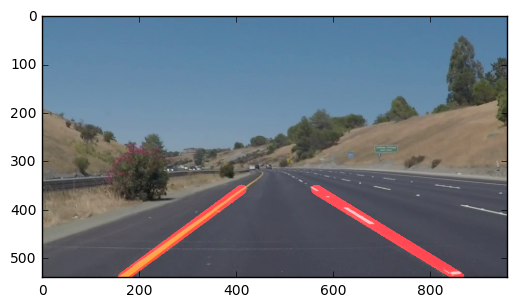

In [66]:
new_clip_output = 'test_output_37.mp4'
test_clip = VideoFileClip("solidYellowLeft.mp4")
#new_clip = test_clip.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV)) #NOTE: this function expects color images!!
#new code to replace above line
new_clip = test_clip.fl_image(process_image)
                            
#%time new_clip.write_videofile(new_clip_output, audio=False)
%time new_clip.write_videofile(new_clip_output, audio=False)

In [67]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))